##### 1. Preparing the Datasets

In [1]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

wine = load_wine()

In [2]:
import numpy as np

zip_test_X = np.genfromtxt('zip.test', delimiter=' ', usecols=np.arange(1, 257))
zip_test_Y = np.genfromtxt('zip.test', delimiter=' ', usecols=0, dtype='int')
zip_train_X = np.genfromtxt('zip.train', delimiter=' ', usecols=np.arange(1, 257))
zip_train_Y = np.genfromtxt('zip.train', delimiter = ' ', usecols=0).astype(int)

zip_X = np.concatenate([zip_test_X, zip_train_X])
zip_Y = np.concatenate([zip_test_Y, zip_train_Y])

#### 2. Splitting into train set and test set

In [3]:
wine_X_train, wine_X_test, wine_y_train, wine_y_test = train_test_split(wine.data, wine.target, random_state=309)
zip_X_train , zip_X_test, zip_y_train, zip_y_test = train_test_split(zip_X, zip_Y, random_state=309)

#### 3. Estimating generalization accuracy

In [4]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

svm = SVC().fit(wine_X_train, wine_y_train)
generalization_accuracy = cross_val_score(svm, wine_X_train, wine_y_train).mean()
print("Generalization Accuracy for the Wine Dataset: ", generalization_accuracy)

Generalization Accuracy for the Wine Dataset:  0.6692307692307693


In [5]:
test_error_rate = 1 - svm.score(wine_X_test, wine_y_test)
print("Test Error Rate for Wine Dataset: ", test_error_rate)

Test Error Rate for Wine Dataset:  0.37777777777777777


In [6]:
svm = SVC().fit(zip_X_train, zip_y_train)
generalization_accuracy = cross_val_score(svm, zip_X_train, zip_y_train).mean()
print("Generalization Accuracy for the Zip Dataset: ", generalization_accuracy)


Generalization Accuracy for the Zip Dataset:  0.9710318158210045


In [7]:
test_error_rate = 1 - svm.score(zip_X_test, zip_y_test)
print("Test Error Rate for Zip Dataset: ", test_error_rate)

Test Error Rate for Zip Dataset:  0.03354838709677421


4. The test error rate for the Zip dataset is basically the complement of the test accuracy for the Zip dataset. When calculating the test accuracy using the test error rate (1 - test_error_rate), we find that the difference between Generalization accuracy and Test accuracy are quite close. This suggests that our model is generalizing well and is probably not overfitted.

#### 5 and 6: Pipeline and GridSearchCV for SVM with training and testing

In [8]:
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import make_pipeline

scalers = [Normalizer(), StandardScaler(), MinMaxScaler(), RobustScaler()]
pipes = [make_pipeline(scaler, SVC()) for scaler in scalers]
wine_grids = []
zip_grids = []
param_grid = {'svc__C': [0.01, 0.1, 1, 10, 100],
              'svc__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

from sklearn.model_selection import GridSearchCV

for pipe in pipes:
    grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
    wine_grids.append(grid)
    grid.fit(wine_X_train, wine_y_train)
    print("--------------- Results for " + str(pipe.steps[0][1]) + " ---------------")
    print("Best cross-validation accuracy:", grid.best_score_)
    print("Test set score:", grid.score(wine_X_test, wine_y_test))
    print("Test error rate:", 1 - grid.score(wine_X_test, wine_y_test))
    print("Best Parameters:", grid.best_params_)

--------------- Results for Normalizer() ---------------
Best cross-validation accuracy: 0.9091168091168091
Test set score: 0.8888888888888888
Test error rate: 0.11111111111111116
Best Parameters: {'svc__C': 100, 'svc__gamma': 10}
--------------- Results for StandardScaler() ---------------
Best cross-validation accuracy: 0.9851851851851852
Test set score: 1.0
Test error rate: 0.0
Best Parameters: {'svc__C': 1, 'svc__gamma': 0.01}
--------------- Results for MinMaxScaler() ---------------
Best cross-validation accuracy: 0.9851851851851852
Test set score: 0.9777777777777777
Test error rate: 0.022222222222222254
Best Parameters: {'svc__C': 10, 'svc__gamma': 0.1}
--------------- Results for RobustScaler() ---------------
Best cross-validation accuracy: 0.9851851851851852
Test set score: 0.9777777777777777
Test error rate: 0.022222222222222254
Best Parameters: {'svc__C': 10, 'svc__gamma': 0.01}


In [9]:
for pipe in pipes:
    grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
    zip_grids.append(grid)
    grid.fit(zip_X_train, zip_y_train)
    print("--------------- Results for " + str(pipe.steps[0][1]) + " ---------------")
    print("Best cross-validation accuracy:", grid.best_score_)
    print("Test set score:", grid.score(zip_X_test, zip_y_test))
    print("Test error rate:", 1 - grid.score(zip_X_test, zip_y_test))
    print("Best Parameters:", grid.best_params_)

--------------- Results for Normalizer() ---------------
Best cross-validation accuracy: 0.9731830733867112
Test set score: 0.9724731182795698
Test error rate: 0.027526881720430163
Best Parameters: {'svc__C': 100, 'svc__gamma': 1}
--------------- Results for StandardScaler() ---------------
Best cross-validation accuracy: 0.9664426651856651
Test set score: 0.9625806451612903
Test error rate: 0.03741935483870973
Best Parameters: {'svc__C': 10, 'svc__gamma': 0.001}
--------------- Results for MinMaxScaler() ---------------
Best cross-validation accuracy: 0.9690239274309252
Test set score: 0.9673118279569892
Test error rate: 0.03268817204301078
Best Parameters: {'svc__C': 10, 'svc__gamma': 0.01}
--------------- Results for RobustScaler() ---------------
Best cross-validation accuracy: 0.9209759182980823
Test set score: 0.9359139784946237
Test error rate: 0.06408602150537634
Best Parameters: {'svc__C': 100, 'svc__gamma': 0.001}


##### 7. Cross-conformal predictor using Normalizer()

In [10]:
from sklearn.model_selection import KFold

class cross_conformal_predictor:
    def __init__(self, X_train, y_train, grid):
        self.grid = grid
        self.X_train = X_train
        self.y_train = y_train
    def cross_conformal_predictor(self, X_samples, y_samples, k_folds:int = 5):
        X_train = self.X_train
        y_train = self.y_train
        n_train = len(X_train)
        labels = set(y_train)
        n_test = len(X_samples)
        p = np.zeros((n_test, len(labels)))
        
        kf = KFold(n_splits=k_folds, shuffle = True, random_state=309)
        
        for rest_index, fold_index in kf.split(X_train, y_train):
            X_rest, X_fold = X_train[rest_index], X_train[fold_index]
            y_rest, y_fold = y_train[rest_index], y_train[fold_index]
            
            self.grid.fit(X_rest, y_rest)
            fold_scores = self.grid.decision_function(X_fold)
            sample_scores = self.grid.decision_function(X_samples)
            true_fold_scores = [(true_class, fold_scores[i][true_class]) for i, true_class in enumerate(y_fold)]
            for i in range(n_test): #check each test sample
                for scores in true_fold_scores: #iterate through fold scores
                    for j in range(len(labels)):
                        if scores[1] <= sample_scores[i][j]:
                            p[i][j] += 1
        for i in range(n_test):
            p[i] = (p[i] + 1)/(n_train + 1)       
        return p
    

In [11]:
ccp = cross_conformal_predictor(wine_X_train, wine_y_train, wine_grids[0])
p_values = ccp.cross_conformal_predictor(wine_X_test, wine_y_test)

In [12]:
import math
p_total = 0
for i, label in enumerate(wine_y_test):
    smallest_p_value = -math.inf
    for prediction, confidence in enumerate(p_values[i]):
        if prediction != label:
            p_total += confidence
print(f"Average false p value for Wine using {pipes[0].steps[0][1]}: ", p_total/(len(wine_X_test)))

Average false p value for Wine using Normalizer():  0.05854063018242121


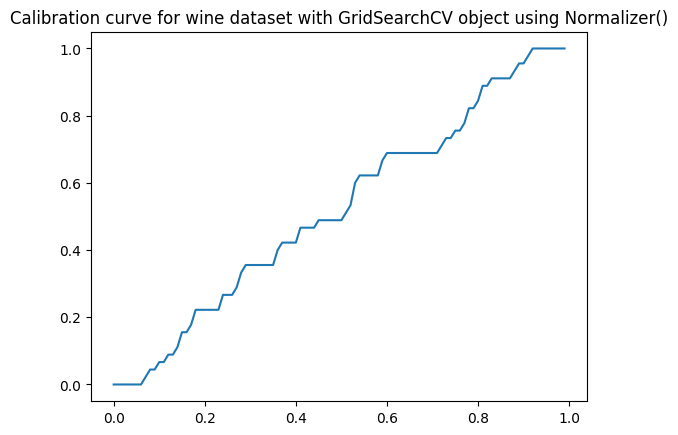

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

eps = np.zeros(100)
err = np.zeros(100)
for k in range(100):
    eps[k] = k/100
    err[k] = 0
    for j in range(wine_X_test.shape[0]):
        if (p_values[j, wine_y_test[j]] <= eps[k]):
            err[k] = err[k] + 1
    err[k] = err[k] / wine_X_test.shape[0]
plt.title(f"Calibration curve for wine dataset with GridSearchCV object using {pipes[0].steps[0][1]}")
plt.plot(eps, err)

In [14]:
ccp = cross_conformal_predictor(zip_X_train, zip_y_train, zip_grids[0])
p_values = ccp.cross_conformal_predictor(zip_X_test, zip_y_test)

In [15]:
p_total = 0
for i, label in enumerate(zip_y_test):
    smallest_p_value = -math.inf
    for prediction, confidence in enumerate(p_values[i]):
        if prediction != label:
            p_total += confidence
print(f"Average false p value for USPS using {pipes[0].steps[0][1]}: ", p_total/(len(zip_X_test)))

Average false p value for USPS using Normalizer():  0.03957309946930784


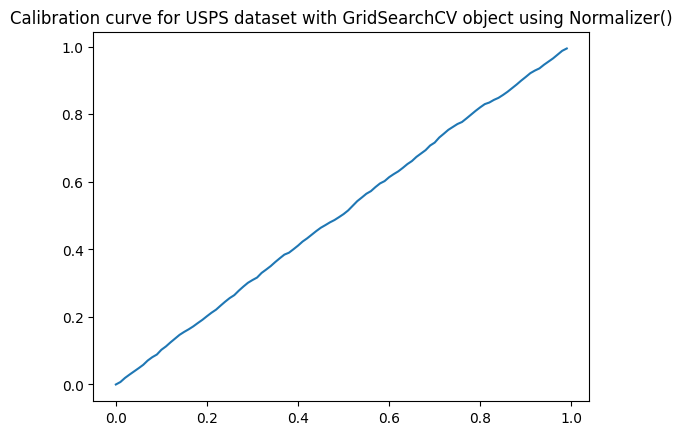

In [16]:
eps = np.zeros(100)
err = np.zeros(100)
for k in range(100):
    eps[k] = k/100
    err[k] = 0
    for j in range(zip_X_test.shape[0]):
        if (p_values[j, zip_y_test[j]] <= eps[k]):
            err[k] = err[k] + 1
    err[k] = err[k] / zip_X_test.shape[0]
plt.title(f"Calibration curve for USPS dataset with GridSearchCV object using {pipes[0].steps[0][1]}")
plt.plot(eps, err)